# General Instructions to students:

1. There are 5 types of cells in this notebook. The cell type will be indicated within the cell.
    1. Markdown cells with problem written in it. (DO NOT TOUCH THESE CELLS) (**Cell type: TextRead**)
    2. Python cells with setup code for further evaluations. (DO NOT TOUCH THESE CELLS) (**Cell type: CodeRead**)
    3. Python code cells with some template code or empty cell. (FILL CODE IN THESE CELLS BASED ON INSTRUCTIONS IN CURRENT AND PREVIOUS CELLS) (**Cell type: CodeWrite**)
    4. Markdown cells where a written reasoning or conclusion is expected. (WRITE SENTENCES IN THESE CELLS) (**Cell type: TextWrite**)
    5. Temporary code cells for convenience and TAs. (YOU MAY DO WHAT YOU WILL WITH THESE CELLS, TAs WILL REPLACE WHATEVER YOU WRITE HERE WITH OFFICIAL EVALUATION CODE) (**Cell type: Convenience**)
    
2. You are not allowed to insert new cells in the submitted notebook.

3. You are not allowed to import any extra packages.

4. The code is to be written in Python 3.6 syntax. Latest versions of other packages maybe assumed.

5. In CodeWrite Cells, the only outputs to be given are plots asked in the question. Nothing else to be output/print. 

6. If TextWrite cells ask you to give accuracy/error/other numbers you can print them on the code cells, but remove the print statements before submitting.

7. The convenience code can be used to check the expected syntax of the functions. At a minimum, your entire notebook must run with "run all" with the convenience cells as it is. Any runtime failures on the submitted notebook as it is will get zero marks.

8. All code must be written by yourself. Copying from other students/material on the web is strictly prohibited. Any violations will result in zero marks.

9. All datasets will be given as .npz files, and will contain data in 4 numpy arrays :"X_train, Y_train, X_test, Y_test". In that order. The meaning of the 4 arrays can be easily inferred from their names.

10. All plots must be labelled properly, all tables must have rows and columns named properly.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import warnings
warnings.filterwarnings('ignore')

# 1. Logistic Regression 

Write code for doing logistic regression below. Also write code for choosing best hyperparameters for each kernel type (use a part of training set as validation set). 

The range of hyperparameters is typically chosen on a log scale e.g. 1e-4, 1e-3, 1e-2... 1e3.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters. 

For the synthetic classification datasets (dataset_A and dataset_B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.


In [0]:
# CodeWrite 
#Write logistic regression code from scratch. Use gradient descent.
# Only write functions here
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def standardise(train_X, test_X):

    #assuming all features are independent and standardising each dimensions seperately
#     temp = np.average(np.power(train_X, 2), axis = 0)
#     temp = np.power(temp, 0.5)
#     train_X /= temp
#     test_X /= temp
    
    return train_X, test_X

def train_pred_logistic_regression(X, Y, kernel='linear', reg_param=0., 
                                   kernel_param=1., num_iter_gd=100):

    mean = np.average(X, axis = 0)
    X = X - mean
    n = X.shape[0]
    k=calc_Kernel(X,X,kernel,kernel_param)
    alpha = np.zeros((n,))
    rate = 5
    term = np.multiply(k, Y)
    term *= -1
    prev_risk = 100000000000000000000
    arg = np.zeros((n,))
    reg = np.zeros((n,))
    for t in range(num_iter_gd):

        multiplier = sigmoid(arg)
        final = np.multiply(term, multiplier)
        #term is multiplied columnwise with -Y[i]
        grad  = np.sum(final, axis = 1)

        grad/=n
        grad += reg
        grad/= np.linalg.norm(grad)
        candidate = alpha
        alpha = alpha - (rate * grad)
        reg = reg_param * np.matmul(k, alpha)
        arg = np.matmul(k, alpha)
        arg = np.multiply(arg, Y)
        arg *= -1
        risk = np.log(1 + np.exp(arg))
        risk = np.sum(risk, axis = 0)
        risk += (np.matmul(alpha.T, reg/2))
        if(risk < prev_risk):
            rate = max(1, (1.1 * rate))
        while(risk > prev_risk):
            rate/=2
            alpha = candidate
            alpha = alpha - (rate * grad)
            reg = reg_param * np.matmul(k, alpha)
            arg = np.matmul(k, alpha)
            arg = np.multiply(arg, Y)
            arg *= -1
            risk = np.log(1 + np.exp(arg))
            risk = np.sum(risk, axis = 0)
            risk += (np.matmul(alpha.T, reg/2))
        prev_risk = risk

    return alpha


def calc_Kernel(X,Y,kernel,kernel_param):
    A=np.matmul(X, Y.T)
    if(kernel=='linear'):
        return A
    elif(kernel=='poly'):
        return np.power(1+A, kernel_param)
    elif(kernel=='rbf'):
        B=np.sum(np.power(X,2), axis=1)
        C=np.sum(np.power(Y,2), axis=1)
        return np.exp(kernel_param*((2*A-C).T-B).T)
    else:
        print("INVALID KERNEL")
        

def test_pred(alpha, train_X, test_X, kernel = 'linear', kernel_param = 1):
    """
    Return the predictions on test_X using the learnt alphas
    """
    mean = np.average(train_X, axis = 0)
    train_X = train_X - mean
    test_X = test_X - mean
    n = train_X.shape[0]
    kernels = calc_Kernel(train_X, test_X, kernel, kernel_param)
    Y = np.matmul(alpha.T, kernels)
    Y = np.sign(Y)
    return Y

    
def getError(Y_pred, Y_test):
    return float(np.sum(Y_test!=Y_pred)/len(Y_test))
                
def choose_hyperparam(X_train, Y_train, X_test, Y_test, kernel_type):
    regularizations = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    kernel_param = [1, 2, 3, 4, 5, 10] if kernel_type=='poly' else [1e-3, 1e-2, 1e-1, 1, 2, 5, 10, 100] 
    curr_param = (0,1)
    curr_err = 1
    X_train, X_test = standardise(X_train, X_test)
    if kernel_type == "rbf" or kernel_type == "poly":
        for reg in regularizations:
            for kp in kernel_param:
                a = train_pred_logistic_regression(X_train, Y_train, kernel = kernel_type, kernel_param = kp, reg_param = reg)
                Y_pred = test_pred(a, X_train, X_test, kernel = kernel_type, kernel_param = kp)
                test_err = getError(Y_pred, Y_test)
                #print(kernel_type, reg, kp, test_err, sep = " ")
                if test_err < curr_err:
                    curr_err = test_err
                    curr_param = (reg, kp)
        return curr_param
    
    elif kernel_type == "linear":
        for reg in regularizations:
            a = train_pred_logistic_regression(X_train, Y_train, kernel = kernel_type, kernel_param = 1, reg_param = reg, num_iter_gd = 100)
            Y_pred = test_pred(a, X_train, X_test, kernel = kernel_type, kernel_param = 1)
            test_err = getError(Y_pred, Y_test)
            #print(kernel_type, reg, test_err, sep = " ")
            if test_err < curr_err:
                curr_err = test_err
                curr_param = (reg, 1)
        return curr_param
                    


In [0]:
# CodeWrite : Use the functions above to do validation to get best hyperparameters 
# (i.e. kernel_param and regularisation_param).
# Also, get the numbers you report below. 

for ch in [ 'A', 'B', 'C', 'D']:
    st_xtr="dataset_"+ch+"/arr_0.npy"
    st_ytr="dataset_"+ch+"/arr_1.npy"
    st_xte="dataset_"+ch+"/arr_2.npy"
    st_yte="dataset_"+ch+"/arr_3.npy"
    
    X_train=np.load(st_xtr)
    Y_train=np.load(st_ytr)
    X_test=np.load(st_xte)
    Y_test=np.load(st_yte)

    #print(str(len(X_train)))
    X_tr=X_train[:int(0.8*(len(X_train)))]
    X_va=X_train[int(0.8*(len(X_train)))+1:]
    Y_tr=Y_train[:int(0.8*(len(Y_train)))]
    Y_va=Y_train[int(0.8*(len(Y_train)))+1:]

    #print("For dataset "+ch)
    
    reg, temp = choose_hyperparam(X_tr, Y_tr, X_va, Y_va, kernel_type = "linear")
    a = train_pred_logistic_regression(X_tr, Y_tr, kernel = "linear", kernel_param = 1, reg_param = reg)
    Y_pred_test = test_pred(a, X_tr, X_test, kernel = "linear", kernel_param = 1)
    Y_pred_train = test_pred(a, X_tr, X_train, kernel = "linear", kernel_param = 1)
    #print("Linear regularisation_parameter is "+str(reg))
    #print("The linear kernel test error is "+str(getError(Y_pred_test, Y_test)))
    #print("The linear kernel train error is "+str(getError(Y_pred_train, Y_train)))
    
    
    reg, kp = choose_hyperparam(X_tr, Y_tr, X_va, Y_va, kernel_type = "rbf")
    a = train_pred_logistic_regression(X_tr, Y_tr, kernel = "rbf", kernel_param = kp, reg_param = reg)
    Y_pred_test = test_pred(a, X_tr, X_test, kernel = "rbf", kernel_param = kp)
    Y_pred_train = test_pred(a, X_tr, X_train, kernel = "rbf", kernel_param = kp)
    # print("RBF regularisation_parameter is "+str(reg))
    # print("RBF kernel parameter is "+str(kp))
    # print("The RBF kernel test error is "+str(getError(Y_pred_test, Y_test)))
    # print("The RBF kernel train error is "+str(getError(Y_pred_train, Y_train)))
   
    

    reg, kp =choose_hyperparam(X_tr, Y_tr, X_va, Y_va, kernel_type = "poly")
    a = train_pred_logistic_regression(X_tr, Y_tr, kernel = "poly", kernel_param = kp, reg_param = reg)
    Y_pred_test = test_pred(a, X_tr, X_test, kernel = "poly", kernel_param = kp)
    Y_pred_train = test_pred(a, X_tr, X_train, kernel = "poly", kernel_param = kp)
    # print("Polynomial regularisation_parameter is "+str(reg))
    # print("Polynomial kernel parameter is "+str(kp))
    # print("The Polynomial kernel test error is "+str(getError(Y_pred_test, Y_test)))
    # print("The Polynomial kernel train error is "+str(getError(Y_pred_train, Y_train)))
   


TextWrite Cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error for all three kernel choices, for all 4 datasets (2 real world and 2 synthetic).  



### Linear Kernel
|dataset\error   | training error  | test error |
|:----------------:|:-----------------:|:------------:|
|**A** | 0.124 | 0.128 |
|**B** | 0.176 | 0.212 |
|**C** | 0.092 | 0.148 |
|**D** | 0.107 | 0.059 |




### Polynomial Kernel
|dataset\error   | training error  | test error |
|:----------------:|:-----------------:|:------------:|
|**A** | 0.002 | 0.004 |
|**B** | 0.185 | 0.220 |
|**C** | 0.004 | 0.020 |
|**D** | 0.107 | 0.059 |




### RBF Kernel
|dataset\error   | training error  | test error |
|:----------------:|:-----------------:|:------------:|
|**A** | 0.002 | 0.004 |
|**B** | 0.176 | 0.202 |
|**C** | 0.001 | 0.033 |
|**D** | 0.010 | 0.112 |



### Best regularisation Parameter
|dataset\type| linear | polynomial | rbf|
|:----------------:|:-----------------:|:------------:|:------------:|
|**A** |0.001 | 0.0001 | 0.0001
|**B** |0.01 |0.1 |0.001
|**C** | 10 | 0.0001| 0.1
|**D** |  0.0001|0.0001 |0.0001

### Best Kernel Parameter

|dataset\type|  polynomial | rbf|
|:----------------:|:-----------------:|:------------:|
|**A** | 5 | 1 |
|**B** | 5 | 0.1 |
|**C** | 5 | 0.1 |
|**D** | 1 |0.001 |

##Observations

1. RBF and Polynomial kernels tend to perform better than linear because they can classify non linear boundaries
2. Seeing A's graph it clearly is not linearly seperable but there exists a very clear decision boundary, therefore A gets a much higher error in linear as compared to polynomial and rbf.
3. For dataset B almost all kernels give the same error, therefore we can conclude that a linear seperator was the best possible seperator
4. For dataset C polynomial and RBF seem to perform a lot better than linear again mostly because the dataset is not linearly seperable
5. In dataset D linear and polynomial seem to work better than RBF and the polynomial degree is also 1, implying that the data is close to linearly seperable.

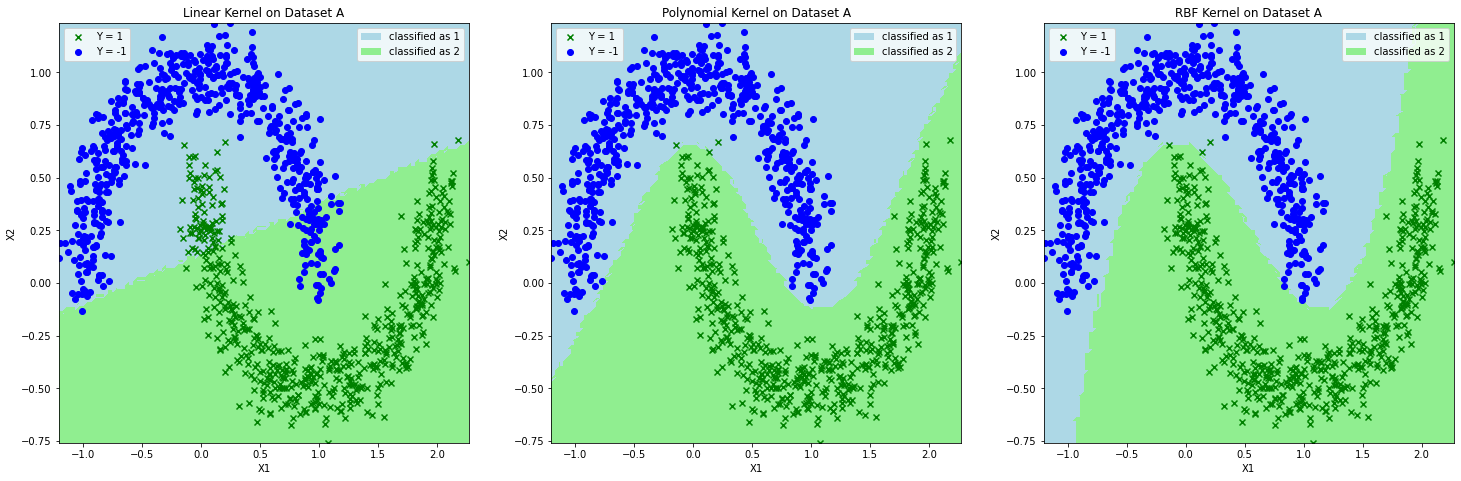

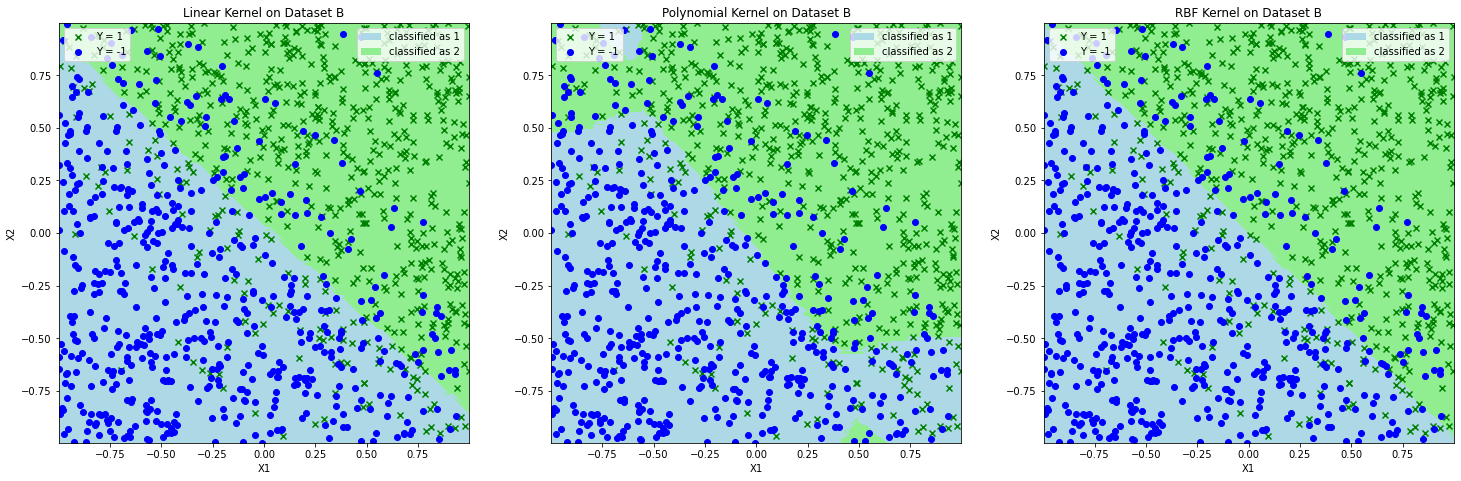

In [0]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6

for ind,ch in enumerate(['A', 'B']):
    st_xtr="dataset_"+ch+"/arr_0.npy"
    st_ytr="dataset_"+ch+"/arr_1.npy"
    st_xte="dataset_"+ch+"/arr_2.npy"
    st_yte="dataset_"+ch+"/arr_3.npy"
    
    X_train=np.load(st_xtr)
    Y_train=np.load(st_ytr)
    X_test=np.load(st_xte)
    Y_test=np.load(st_yte)

    #print(str(len(X_train)))
    X_tr=X_train[:int(0.8*(len(X_train)))]
    X_va=X_train[int(0.8*(len(X_train)))+1:]
    Y_tr=Y_train[:int(0.8*(len(Y_train)))]
    Y_va=Y_train[int(0.8*(len(Y_train)))+1:]
    
    reg_param_linear, temp =choose_hyperparam(X_tr, Y_tr, X_va, Y_va, kernel_type = "linear")
    reg_param_poly, degree_poly=choose_hyperparam(X_tr, Y_tr, X_va, Y_va, kernel_type = "poly")
    reg_param_rbf, kp=choose_hyperparam(X_tr, Y_tr, X_va, Y_va, kernel_type = "rbf")
    
    n1=100
    n2=100
    x1 = np.linspace(np.min(X_tr.T[0]),np.max(X_tr.T[0]),n1)
    x2 = np.linspace(np.min(X_tr.T[1]),np.max(X_tr.T[1]),n2)
    x1,x2 = np.meshgrid(x1,x2)
    x1 = x1.reshape((n1*n2,1))
    x2 = x2.reshape((n1*n2,1))
    x  = np.concatenate((x1,x2),axis=1)
    x1 =x1.reshape((n1,n2))
    x2 =x2.reshape((n1,n2))
    
    alphaL = train_pred_logistic_regression(X_tr, Y_tr, kernel ="linear", reg_param = reg_param_linear, num_iter_gd = 100)
    yl = test_pred(alphaL, X_tr, x, kernel = "linear", kernel_param = 1)
    alphaP = train_pred_logistic_regression(X_tr, Y_tr, kernel ="poly", reg_param = reg_param_poly, kernel_param = degree_poly, num_iter_gd = 100)
    yp = test_pred(alphaP, X_tr, x, kernel = "poly", kernel_param = degree_poly)
    alphaR = train_pred_logistic_regression(X_tr, Y_tr, kernel ="rbf", reg_param = reg_param_rbf, kernel_param = kp, num_iter_gd = 100)
    yr = test_pred(alphaR, X_tr, x, kernel = "rbf", kernel_param = kp)
    yl=yl.reshape((n1,n2))
    yp=yp.reshape((n1,n2))
    yr=yr.reshape((n1,n2))
    
    
    plt.figure(figsize = (25,17))
    plt.subplot(2,3,3*ind+1)
    plt.gca().set_title("Linear Kernel on Dataset "+ch)
    plt.gca().set_ylabel("X2")
    plt.gca().set_xlabel("X1")
    a=plt.contourf(x1,x2,yl,colors = ["lightblue", "lightgreen"])
    plt.scatter(X_tr[Y_tr==1].T[0], X_tr[Y_tr==1].T[1], c="g", label = "Y = 1", marker = 'x')
    plt.scatter(X_tr[Y_tr==-1].T[0], X_tr[Y_tr==-1].T[1], c="b", label= "Y = -1", marker = 'o')
    contour = plt.legend(loc = "upper left")
    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in a.collections]
    plt.legend(proxy, ["classified as " + str(i+1) for i in range(2)], loc = "upper right")    
    plt.gca().add_artist(contour)

    
    plt.subplot(2,3,3*ind+2)
    plt.gca().set_title("Polynomial Kernel on Dataset "+ch)
    plt.gca().set_ylabel("X2")
    plt.gca().set_xlabel("X1")
    a=plt.contourf(x1,x2,yp,colors = ["lightblue", "lightgreen"])
    plt.scatter(X_tr[Y_tr==1].T[0], X_tr[Y_tr==1].T[1], c="g", label = "Y = 1", marker = 'x')
    plt.scatter(X_tr[Y_tr==-1].T[0], X_tr[Y_tr==-1].T[1], c="b", label= "Y = -1", marker = 'o')
    contour = plt.legend(loc = "upper left")
    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in a.collections]
    plt.legend(proxy, ["classified as " + str(i+1) for i in range(2)], loc = "upper right")    
    plt.gca().add_artist(contour)
    
    
   
    plt.subplot(2,3,3*ind+3)
    plt.gca().set_title("RBF Kernel on Dataset "+ch)
    plt.gca().set_ylabel("X2")
    plt.gca().set_xlabel("X1")
    a=plt.contourf(x1,x2,yr,colors = ["lightblue", "lightgreen"])
    plt.scatter(X_tr[Y_tr==1].T[0], X_tr[Y_tr==1].T[1], c="g", label = "Y = 1", marker = 'x')
    plt.scatter(X_tr[Y_tr==-1].T[0], X_tr[Y_tr==-1].T[1], c="b", label= "Y = -1", marker = 'o')
    contour = plt.legend(loc = "upper left")
    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in a.collections]
    plt.legend(proxy, ["classified as " + str(i+1) for i in range(2)], loc = "upper right")    
    plt.gca().add_artist(contour)
    


# 2. SVM

Write code for learning SVM below. Also write code for choosing best hyperparameters for each kernel type. You may use sklearn.svm for this purpose. (use a part of training set as validation set)

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [0]:
# CodeWrite cell
# Write SVM classifier using SKlearn
# write only functions here
def train_and_predict_linear(X_train, Y_train, X_valid, reg_param):
    clf=svm.SVC(C=reg_param, kernel='linear')
    clf.fit(X_train, Y_train)
    return np.asarray(clf.predict(X_valid))
def train_and_predict_polynomial(X_train, Y_train, X_valid, reg_param, kernel_param):
    clf=svm.SVC(C=reg_param, kernel='poly', degree=kernel_param, coef0 =1 ,gamma =1,max_iter = 500000)
    clf.fit(X_train, Y_train)
    return np.asarray(clf.predict(X_valid))
def train_and_predict_rbf(X_train, Y_train, X_valid, reg_param, kernel_param):
    clf=svm.SVC(C=reg_param, kernel='rbf', gamma=kernel_param)
    clf.fit(X_train, Y_train)
    return np.asarray(clf.predict(X_valid))
def error(Y_test, Y_pred):
    return float(np.sum(Y_test!=Y_pred)/len(Y_test))
def choose_hyperparam_linear(X_train, Y_train, X_valid, Y_valid):
    reg_param_all=[1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e+1]
    best_reg=0
    err=10
    for reg_param in reg_param_all:
        Y_pred=train_and_predict_linear(X_train, Y_train, X_valid, reg_param)
        #print(reg_param)
        if(error(Y_pred, Y_valid)<err):
            best_reg=reg_param
            err=error(Y_pred, Y_valid)
    return best_reg
def choose_hyperparam_poly(X_train, Y_train, X_valid, Y_valid):
    reg_param_all=[1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+2]
    degree_all=[2,3,4,5,6]
    best_reg=0
    best_deg=0
    err=10
    for reg_param in reg_param_all:
        for deg in degree_all:
            Y_pred=train_and_predict_polynomial(X_train, Y_train, X_valid, reg_param, deg)
            if(error(Y_pred, Y_valid)<err):
                best_reg=reg_param
                best_deg=deg
                err=error(Y_pred, Y_valid)
    return best_reg, best_deg
def choose_hyperparam_rbf(X_train, Y_train, X_valid, Y_valid):
    reg_param_all=[ 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e+1]
    rbf_param_all=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e+1]
    best_reg=0
    best_ker=0
    err=10
    for reg_param in reg_param_all:
        for ker in rbf_param_all:
            Y_pred=train_and_predict_rbf(X_train, Y_train, X_valid, reg_param, ker)
            if(error(Y_pred, Y_valid)<err):
                best_reg=reg_param
                best_ker=ker
                err=error(Y_pred, Y_valid)
    return best_reg, best_ker

In [0]:
# CodeWrite cell
# Write code here for doing validation (for kernel_param and regularisation_param)
# on a subset of the training set. 
# Also for generating the numbers that you report below.
def error(Y_test, Y_pred):
    return float(np.sum(Y_test!=Y_pred)/len(Y_test))
for ch in ['A','B','C','D']:
    st_xtr="dataset_"+ch+"/arr_0.npy"
    st_ytr="dataset_"+ch+"/arr_1.npy"
    st_xte="dataset_"+ch+"/arr_2.npy"
    st_yte="dataset_"+ch+"/arr_3.npy"
    
    X_train=np.load(st_xtr)
    Y_train=np.load(st_ytr)
    X_test=np.load(st_xte)
    Y_test=np.load(st_yte)

    #print(str(len(X_train)))
    X_tr=X_train[:int(0.8*(len(X_train)))]
    X_va=X_train[int(0.8*(len(X_train)))+1:]
    Y_tr=Y_train[:int(0.8*(len(Y_train)))]
    Y_va=Y_train[int(0.8*(len(Y_train)))+1:]
    
    #print("For dataset "+ch)
    reg_param_linear=choose_hyperparam_linear(X_tr, Y_tr, X_va, Y_va)
    Y_te_lin =train_and_predict_linear(X_tr, Y_tr, X_test, reg_param_linear)
    Y_tr_lin =train_and_predict_linear(X_tr, Y_tr, X_tr, reg_param_linear)
    #print("Linear regularisation_parameter is "+str(reg_param_linear))
    #print("The linear kernel test error is "+str(error(Y_te_lin,Y_test)))
    #print("The linear kernel train error is "+str(error(Y_tr_lin,Y_tr)))
    
    
    reg_param_rbf, kernel_param=choose_hyperparam_rbf(X_tr, Y_tr, X_va, Y_va)
    Y_te_rbf =train_and_predict_rbf(X_tr, Y_tr, X_test, reg_param_rbf, kernel_param)
    Y_tr_rbf =train_and_predict_rbf(X_tr, Y_tr, X_tr, reg_param_rbf, kernel_param)
    # print("RBF regularisation_parameter is "+str(reg_param_rbf))
    # print("RBF kernel parameter is "+str(kernel_param))
    # print("The RBF kernel test error is "+str(error(Y_te_rbf,Y_test)))
    # print("The RBF kernel train error is "+str(error(Y_tr_rbf,Y_tr)))
   
    
    
    
    reg_param_poly, degree_poly=choose_hyperparam_poly(X_tr, Y_tr, X_va, Y_va)
    Y_te_poly=train_and_predict_polynomial(X_tr, Y_tr, X_test, reg_param_poly, degree_poly)
    Y_tr_poly=train_and_predict_polynomial(X_tr, Y_tr, X_tr, reg_param_poly, degree_poly)
    # print("Polynomial regularisation parameter is "+str(reg_param_poly))
    # print("Polynomial kernel parameter is "+str(degree_poly))
    # print("The Polynomial kernel test error is "+str(error(Y_te_poly,Y_test)))
    # print("The Polynomial kernel train error is "+str(error(Y_tr_poly,Y_tr)))
    

TextWrite Cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error for all three kernel choices, for all 4 datasets (2 real world and 2 synthetic).    


### Linear Kernel
|dataset\error   | training error  | test error |
|:----------------:|:-----------------:|:------------:|
|**A** |  0.127  | 0.128 |
|**B** | 0.170 | 0.196 |
|**C**| 0.085 | 0.110 |
|**D**|0.037 | 0.059 |

### Polynomial Kernel
|dataset\error   | training error  | test error |
|:----------------:|:-----------------:|:------------:|
|**A** |  0.003  | 0.004 |
|**B** | 0.172 | 0.194 |
|**C**| 0.000 | 0.033 |
|**D**| 0.071|	0.059|

### RBF Kernel
|dataset\error   | training error  | test error |
|:----------------:|:-----------------:|:------------:|
|**A** | 0.001 | 0.002 |
|**B** | 0.171 | 0.196 |
|**C**|  0.000 | 0.016 |
|**D**| 0.028 | 0.076|

### Best regularisation Parameter
|dataset\type| linear | polynomial | rbf|
|:----------------:|:-----------------:|:------------:|:------------:|
|       **A**         |      0.1   | 0.01       | 0.1     |
|       **B**         |       1  |     0.01  |  10    |
|       **C**         |    1e-4    |    1e-7    | 1e-3       |
|       **D**         |    1    |    1e-5    |      10.0  |     |

### Best Kernel Parameter

|dataset\type|  polynomial | rbf|
|:----------------:|:-----------------:|:------------:|
|      **A**         |      5   | 10       | 
|      **B**         |      6  |     10  | 
|      **C**         |     4   |    10    |
|      **D**         |      2  |    0.0001    |  

##Observations

1. RBF and Polynomial kernels tend to perform better than linear because they can classify non linear boundaries

2. Seeing A's graph it clearly is not linearly seperable but there exists a very clear decision boundary, therefore A gets a much higher error in linear as compared to polynomial and rbf.

3. C has the least regularisation parameters for all types of kernels implying that there are no outliers in the data, while B has the largest regularisation parameters implying that there are many outliers.

4.  Dataset D must have a very close to being linearly seperable because Linear classifier works as well as Polynomial and RBF, this can also be seen as the best fitting polynomial kernel has the least degree compared to other datasets

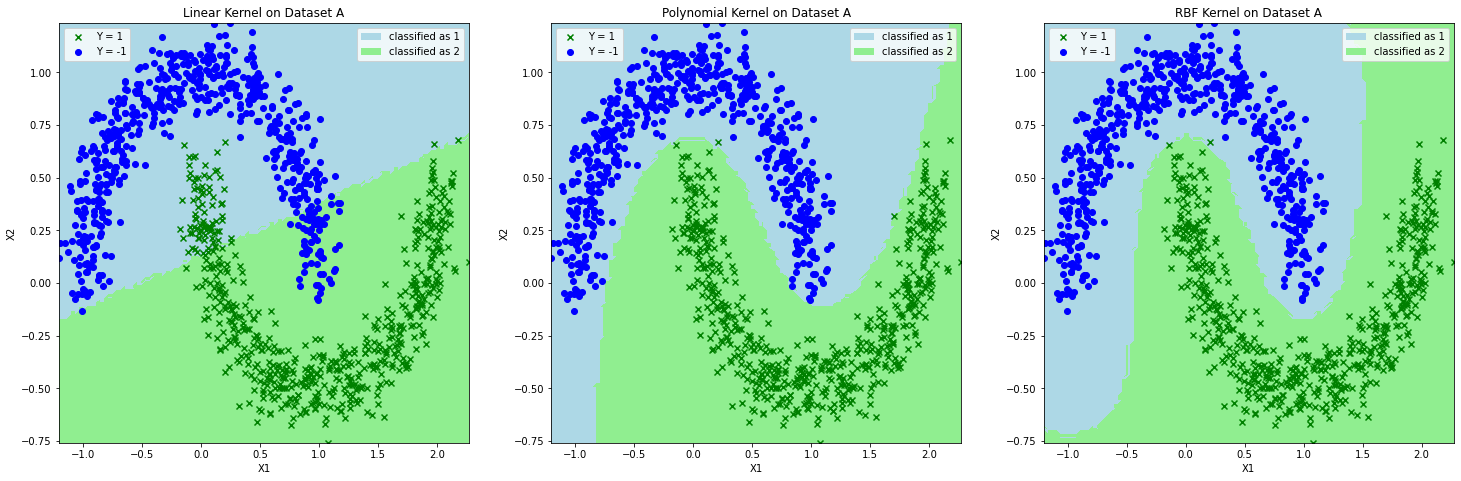

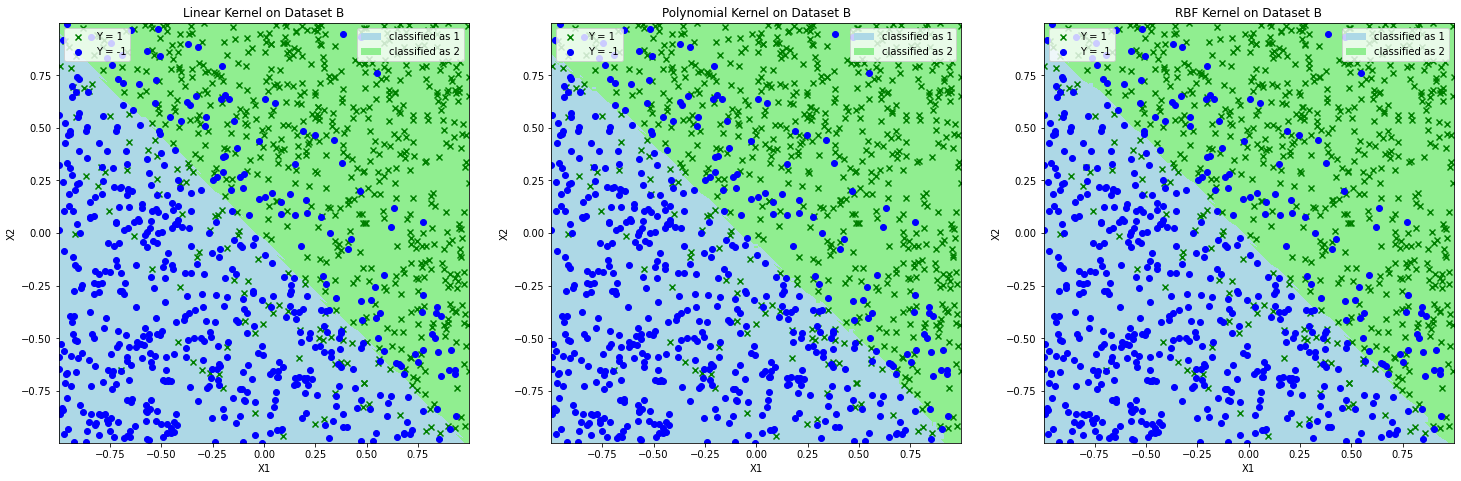

In [8]:
  # Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6
for ind,ch in enumerate(['A', 'B']):
    st_xtr="dataset_"+ch+"/arr_0.npy"
    st_ytr="dataset_"+ch+"/arr_1.npy"
    st_xte="dataset_"+ch+"/arr_2.npy"
    st_yte="dataset_"+ch+"/arr_3.npy"
    
    X_train=np.load(st_xtr)
    Y_train=np.load(st_ytr)
    X_test=np.load(st_xte)
    Y_test=np.load(st_yte)

    #print(str(len(X_train)))
    X_tr=X_train[:int(0.8*(len(X_train)))]
    X_va=X_train[int(0.8*(len(X_train)))+1:]
    Y_tr=Y_train[:int(0.8*(len(Y_train)))]
    Y_va=Y_train[int(0.8*(len(Y_train)))+1:]
    
    reg_param_linear=choose_hyperparam_linear(X_tr, Y_tr, X_va, Y_va)
    reg_param_poly, degree_poly=choose_hyperparam_poly(X_tr, Y_tr, X_va, Y_va)
    reg_param_rbf, kernel_param=choose_hyperparam_rbf(X_tr, Y_tr, X_va, Y_va)
    
    n1=100
    n2=100
    x1 = np.linspace(np.min(X_tr.T[0]),np.max(X_tr.T[0]),n1)
    x2 = np.linspace(np.min(X_tr.T[1]),np.max(X_tr.T[1]),n2)
    x1,x2 = np.meshgrid(x1,x2)
    x1 = x1.reshape((n1*n2,1))
    x2 = x2.reshape((n1*n2,1))
    x  = np.concatenate((x1,x2),axis=1)
    x1 =x1.reshape((n1,n2))
    x2 =x2.reshape((n1,n2))

    yl = train_and_predict_linear(X_tr, Y_tr, x,reg_param_linear )
    yp = train_and_predict_polynomial(X_tr, Y_tr, x, reg_param_poly, degree_poly)
    yr = train_and_predict_rbf(X_tr, Y_tr, x, reg_param_rbf, kernel_param)
    
    yl=yl.reshape((n1,n2))
    yp=yp.reshape((n1,n2))
    yr=yr.reshape((n1,n2))
    
    
    plt.figure(figsize = (25,17))
    plt.subplot(2,3,3*ind+1)
    plt.gca().set_title("Linear Kernel on Dataset "+ch)
    plt.gca().set_ylabel("X2")
    plt.gca().set_xlabel("X1")
    a=plt.contourf(x1,x2,yl,colors = ["lightblue", "lightgreen"])
    plt.scatter(X_tr[Y_tr==1].T[0], X_tr[Y_tr==1].T[1], c="g", label = "Y = 1", marker = 'x')
    plt.scatter(X_tr[Y_tr==-1].T[0], X_tr[Y_tr==-1].T[1], c="b", label= "Y = -1", marker = 'o')
    contour = plt.legend(loc = "upper left")
    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in a.collections]
    plt.legend(proxy, ["classified as " + str(i+1) for i in range(2)], loc = "upper right")    
    plt.gca().add_artist(contour)

    
    plt.subplot(2,3,3*ind+2)
    plt.gca().set_title("Polynomial Kernel on Dataset "+ch)
    plt.gca().set_ylabel("X2")
    plt.gca().set_xlabel("X1")
    a=plt.contourf(x1,x2,yp,colors = ["lightblue", "lightgreen"])
    plt.scatter(X_tr[Y_tr==1].T[0], X_tr[Y_tr==1].T[1], c="g", label = "Y = 1", marker = 'x')
    plt.scatter(X_tr[Y_tr==-1].T[0], X_tr[Y_tr==-1].T[1], c="b", label= "Y = -1", marker = 'o')
    contour = plt.legend(loc = "upper left")
    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in a.collections]
    plt.legend(proxy, ["classified as " + str(i+1) for i in range(2)], loc = "upper right")    
    plt.gca().add_artist(contour)
    
    
   
    plt.subplot(2,3,3*ind+3)
    plt.gca().set_title("RBF Kernel on Dataset "+ch)
    plt.gca().set_ylabel("X2")
    plt.gca().set_xlabel("X1")
    a=plt.contourf(x1,x2,yr,colors = ["lightblue", "lightgreen"])
    plt.scatter(X_tr[Y_tr==1].T[0], X_tr[Y_tr==1].T[1], c="g", label = "Y = 1", marker = 'x')
    plt.scatter(X_tr[Y_tr==-1].T[0], X_tr[Y_tr==-1].T[1], c="b", label= "Y = -1", marker = 'o')
    contour = plt.legend(loc = "upper left")
    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in a.collections]
    plt.legend(proxy, ["classified as " + str(i+1) for i in range(2)], loc = "upper right")    
    plt.gca().add_artist(contour)
    
    


# 3. Decision Tree

Write code for learning decision tree below. Take as an argument a hyperparameter on what size node to stop splitting. Use a part of training set as validation set.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For synthetic data sets (dataset A and dataset B) report the best node size to stop splitting. Report the training and test zero-one error for those hyperparameters.

For datasets A and B, also illustrate the learned classifier. Do this in the last codeWrite cell for this question.

Important: Think about how you will represent a decision tree. (Possible soln: Store as a list of tuples containing node position, attribute to split, threshold, class to classifiy (if leaf node) )


In [0]:
# CodeWrite cell
# Write Decision tree classifier from scratch, 
# write only functions here (you may write extra functions here if you wish)
class Node(object): 
    def __init__(self,attribute,threshold): 
        self.left = None
        self.right = None
        self.thr = threshold
        self.att = attribute
        self.cl = None
        self.leaf = False

def best_split_accuracy(X,Y):
    n,d=X.shape
    batt=1
    bacc=0
    bthr=0
    for att in range(d):
        alr=X[:,att]
        alrc=alr.copy()
        alrc=np.sort(alrc)
        orde=np.argsort(alr)
        ytc=Y.copy()
        ytc=ytc[orde]
        
        pos=np.sum(Y==1)
        neg=len(Y)-pos
        
        pos_b=0
        neg_b=0
        for i in range(n-1):
            if(ytc[i]==1):
                pos_b+=1
            else:
                neg_b+=1
                
            acc1=pos_b/n+(neg-neg_b)/n
            acc2=neg_b/n+(pos-pos_b)/n
            acc=max(acc1, acc2)
            
            if(acc>bacc):
                bacc=acc
                batt=att
                bthr=alrc[i]
    return batt, bthr

def H(p):
    if p==0 or p==1:
        return 0
    else:
        return (p*np.log2(1/p)+(1-p)*np.log2(1/(1-p)))


def best_split_entropy(X,Y):
    n,d=X.shape
    batt=1
    bent=100000000000000
    bthr=0
    for att in range(d):
        alr=X[:,att]
        alrc=alr.copy()
        alrc=np.sort(alrc)
        orde=np.argsort(alr)
        ytc=Y.copy()
        ytc=ytc[orde]

        pos=np.sum(Y==1)
        neg=len(Y)-pos

        pos_b=0
        neg_b=0
        for i in range(n-1):
            if(ytc[i]==1):
                pos_b+=1
            else:
                neg_b+=1

            pL=(i+1)/n
            pR=1-pL
            ent1=pL*H(pos_b/(i+1))+pR*H((pos-pos_b)/(n-1-i))
            ent2=pL*H(neg_b/(i+1))+pR*H((neg-neg_b)/(n-1-i))
            ent=min(ent1, ent2)
            if(ent<bent):
                bent=ent
                batt=att
                bthr=alrc[i]
    return batt, bthr

def best_split(X,Y,criterion):
    if(criterion=='accuracy'):
        return best_split_accuracy(X,Y)
    else:
        return best_split_entropy(X,Y)

lpos=-1
lneg=-1
def train_decision_tree(X, Y, num_nodes_stop=1, criterion='accuracy'):
    """ 
    Returns a decision tree trained on X and Y. 
    Stops splitting nodes when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Returns a tree (In whatever format that you find appropriate)
    """
    global lpos, lneg
    pos=np.sum(Y==1)
    neg=len(Y)-pos
    if pos==0 or neg==0 or pos+neg<=num_nodes_stop or (lpos==pos and lneg==neg) or pos/(pos+neg)>=0.95 or neg/(pos+neg)>=0.95:
        lf=Node(None, None)
        lf.leaf=True
        lf.cl=1 if pos>neg else -1
        return lf
    else:
        batt, bthr=best_split(X,Y,criterion)
        #print(batt, bthr)
        tree=Node(batt,bthr)
        X_l=X[X[:,batt]<=bthr]
        X_r=X[X[:,batt]>bthr]
        Y_l=Y[X[:,batt]<=bthr]
        Y_r=Y[X[:,batt]>bthr]
        lpos=pos
        lneg=neg
        
        tree.left=train_decision_tree(X_l, Y_l, num_nodes_stop, criterion)
        tree.right=train_decision_tree(X_r, Y_r, num_nodes_stop, criterion)
        return tree

def eval_once(tree, x):
    if tree.leaf==True:
        return tree.cl
    elif x[tree.att]<=tree.thr:
        return eval_once(tree.left, x)
    else:
        return eval_once(tree.right, x) 
    
def eval_decision_tree(tree, test_X):
    """ 
    Takes in a tree, and a bunch of instances X and 
    returns the tree predicted values at those instances.
    """
    Y_test_pred = np.zeros(len(test_X))
    for ind in range(len(test_X)):
        Y_test_pred[ind]=eval_once(tree, test_X[ind])
    return Y_test_pred

def train_and_predict_dec_tree(X, Y, num_nodes_stop, criterion, X_test):
    tree=train_decision_tree(X,Y,num_nodes_stop, criterion)
    return eval_decision_tree(tree, X_test)

In [0]:
# CodeWrite cell
# Write code here for doing validation to find the best hyperparameters (i.e. num_nodes_stop)
# Also Generate the numbers that you report below. 
# Repeat with criterion set to entropy also.

def choose_best_hyper_param_dec_tree(X_tr, Y_tr, X_va, Y_va, node_size, crit):
    best_err=10
    best_num=-1
    for num in  node_size:
        tree=train_decision_tree(X_tr, Y_tr, num, crit)
        Y_pr=eval_decision_tree(tree, X_va)
        err=error(Y_pr, Y_va)
        if(err<best_err):
            best_num=num
            best_err=err
    return best_num, best_err
    
def tree_comp(X_tr, Y_tr, X_va, Y_va, node_size, crit, X_test):
    best_num, best_err=choose_best_hyper_param_dec_tree(X_tr, Y_tr, X_va, Y_va, node_size, crit)
    return train_and_predict_dec_tree(X_tr, Y_tr, best_num, criterion)

def error(Y_test, Y_pred):
    return np.sum(Y_test!=Y_pred)/len(Y_test)

for ch in ['A', 'B','C','D']:
    st_xtr="dataset_"+ch+"/arr_0.npy"
    st_ytr="dataset_"+ch+"/arr_1.npy"
    st_xte="dataset_"+ch+"/arr_2.npy"
    st_yte="dataset_"+ch+"/arr_3.npy"

    X_train=np.load(st_xtr)
    Y_train=np.load(st_ytr)
    X_test=np.load(st_xte)
    Y_test=np.load(st_yte)

    #print(str(len(X_train)))
    X_tr=X_train[:int(0.8*(len(X_train)))]
    X_va=X_train[int(0.8*(len(X_train))):]
    Y_tr=Y_train[:int(0.8*(len(Y_train)))]
    Y_va=Y_train[int(0.8*(len(Y_train))):]
    node_size=[1,2,3,4,8,12,16,24,45,55,64]
    criterion=['accuracy', 'entropy']

    erro=[]
    for crit in criterion:
        best_num, best_err=choose_best_hyper_param_dec_tree(X_tr, Y_tr, X_va, Y_va, node_size, crit)
        print("For dataset "+ch+": ")
        print("For criterion "+crit)
        print("The best stopping size is "+str(best_num)+" and the least validation error is "+str(best_err))
        print("The training error is "+str(error(train_and_predict_dec_tree(X_tr, Y_tr, best_num, crit, X_tr), Y_tr)))
        print("The test error is "+str(error(train_and_predict_dec_tree(X_tr, Y_tr, best_num, crit, X_test), Y_test)))

TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic).  

### Accuracy Criterion
|dataset\error   | training error  | test error |
|:----------------:|:-----------------:|:------------:|
|**A** |  0.025  | 0.072 |
|**B** | 0.138 | 0.210 |
|**C**| 0.110 | 0.161 |
|**D**|0.040|0.130|

### Entropy Criterion
|dataset\error   | training error  | test error |
|:----------------:|:-----------------:|:------------:|
|**A** |  0.001  | 0.010 |
|**B** | 0.126 | 0.210 |
|**C**| 0.026 | 0.101 |
|**D**|0.012 |0.071|

### Best node stopping size
|dataset\criterion| accuracy | entropy |
|:----------------:|:-----------------:|:------------:|
|     **A**   |    3     |    1    |
|     **B**     |    12    |    45   |
|     **C**       |    45    |    4    |
|     **D**         |    1     |    1    |

## Observations

1. Generally Entropy works better than accuracy as a splitting parameter
2. B's best node stopping size is larger than most therefore we conclude that the data turns out to be more random than others.
3. The training error seems to be quite a bit lower than test error, so there might be some overfitting

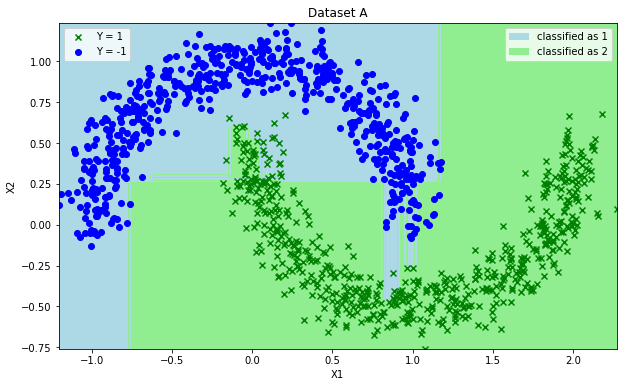

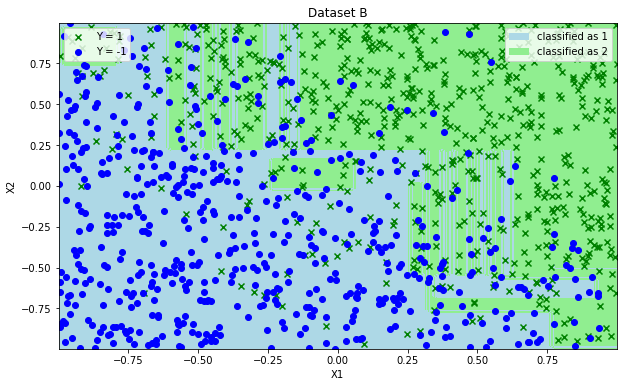

In [0]:
## Codewrite cell: Generate plots of learned decision tree classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots only required for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 
num=[3,12]
for ind, ch in enumerate(['A', 'B']):
    st_xtr="dataset_"+ch+"/arr_0.npy"
    st_ytr="dataset_"+ch+"/arr_1.npy"
    st_xte="dataset_"+ch+"/arr_2.npy"
    st_yte="dataset_"+ch+"/arr_3.npy"
    
    X_train=np.load(st_xtr)
    Y_train=np.load(st_ytr)
    X_test=np.load(st_xte)
    Y_test=np.load(st_yte)

    #print(str(len(X_train)))
    X_tr=X_train[:int(0.8*(len(X_train)))]
    Y_tr=Y_train[:int(0.8*(len(Y_train)))]
    
    tree=train_decision_tree(X_tr, Y_tr, num[ind], 'accuracy')
    
    n1=100
    n2=100
    x1 = np.linspace(np.min(X_tr.T[0]),np.max(X_tr.T[0]),n1)
    x2 = np.linspace(np.min(X_tr.T[1]),np.max(X_tr.T[1]),n2)
    x1,x2 = np.meshgrid(x1,x2)
    x1 = x1.reshape((n1*n2,1))
    x2 = x2.reshape((n1*n2,1))
    x  = np.concatenate((x1,x2),axis=1)
    x1 =x1.reshape((n1,n2))
    x2 =x2.reshape((n1,n2))

    yp=eval_decision_tree(tree,x)
    yp =yp.reshape((n1,n2))
    
    plt.figure(figsize = (10,6))
    plt.gca().set_title("Dataset "+ch)
    plt.gca().set_ylabel("X2")
    plt.gca().set_xlabel("X1")
    a=plt.contourf(x1,x2,yp,colors = ["lightblue", "lightgreen"])
    plt.scatter(X_tr[Y_tr==1].T[0], X_tr[Y_tr==1].T[1], c="g", label = "Y = 1", marker = 'x')
    plt.scatter(X_tr[Y_tr==-1].T[0], X_tr[Y_tr==-1].T[1], c="b", label= "Y = -1", marker = 'o')
    contour = plt.legend(loc = "upper left")
    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in a.collections]
    plt.legend(proxy, ["classified as " + str(i+1) for i in range(2)], loc = "upper right")    
    plt.gca().add_artist(contour)
    plt.show()

# 4 Random Forest classifier

Write code for learning RandomForests below. Fix the following hyper parameters: (Fraction of data to learn tree=0.5, Fraction of number of features chosen in each node=0.5).  Choose the number of trees to add in the forest by using a validation set. You may use a slightly modified version of the decision tree code you had written earlier.

Write code for running in the cell after the nest. (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  report the best number of trees found. Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [0]:
# CodeWrite cell
# Write Random Forest classifier. 

class Node(object): 
    def __init__(self,attribute,threshold): 
        self.left = None
        self.right = None
        self.thr = threshold
        self.att = attribute
        self.cl = None
        self.leaf = False

def best_split_accuracy(X,Y,b):
    n,d=X.shape
    batt=1
    bacc=0
    bthr=0
    c_att=np.sort(np.random.choice(d,int(d*b),replace=False))
    for att in c_att:
        alr=X[:,att]
        alrc=alr.copy()
        alrc=np.sort(alrc)
        orde=np.argsort(alr)
        ytc=Y.copy()
        ytc=ytc[orde]
        
        pos=np.sum(Y==1)
        neg=len(Y)-pos
        
        pos_b=0
        neg_b=0
        for i in range(1,n-1):
            if(ytc[i]==1):
                pos_b+=1
            else:
                neg_b+=1
                
            acc1=pos_b/n+(neg-neg_b)/n
            acc2=neg_b/n+(pos-pos_b)/n
            acc=max(acc1, acc2)
            
            if(acc>bacc):
                bacc=acc
                batt=att
                bthr=alrc[i]
    return batt, bthr

def H(p):
    if p==0 or p==1:
        return 0
    else:
        return (p*np.log2(1/p)+(1-p)*np.log2(1/(1-p)))


def best_split_entropy(X,Y,b):
    n,d=X.shape
    batt=1
    bent=100000000000000
    bthr=0
    c_att=np.sort(np.random.choice(d,int(d*b),replace=False))
    for att in c_att:
        alr=X[:,att]
        alrc=alr.copy()
        alrc=np.sort(alrc)
        orde=np.argsort(alr)
        ytc=Y.copy()
        ytc=ytc[orde]

        pos=np.sum(Y==1)
        neg=len(Y)-pos

        pos_b=0
        neg_b=0
        for i in range(1,n-1):
            if(ytc[i]==1):
                pos_b+=1
            else:
                neg_b+=1

            pL=(i+1)/n
            pR=1-pL
            ent1=pL*H(pos_b/(i+1))+pR*H((pos-pos_b)/(n-1-i))
            ent2=pL*H(neg_b/(i+1))+pR*H((neg-neg_b)/(n-1-i))
            ent=min(ent1, ent2)
            #print(acc)
            if(ent<bent):
                bent=ent
                batt=att
                bthr=alrc[i]
    return batt, bthr

def best_split(X,Y,criterion,b):
    if(criterion=='accuracy'):
        return best_split_accuracy(X,Y,b)
    else:
        return best_split_entropy(X,Y,b)

lpos=-1
lneg=-1
def train_decision_tree(X, Y,num_nodes_stop=1, criterion='accuracy', b=0.5):
    """ 
    Returns a decision tree trained on X and Y. 
    Stops splitting nodes when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Returns a tree (In whatever format that you find appropriate)
    """
    global lpos, lneg
    pos=np.sum(Y==1)
    neg=len(Y)-pos
    if pos==0 or neg==0 or pos+neg<=num_nodes_stop or (lpos==pos and lneg==neg):
        lf=Node(None, None)
        lf.leaf=True
        lf.cl=1 if pos>neg else -1
        return lf
    else:
        batt, bthr=best_split(X,Y,criterion,b)
        #print(batt, bthr)
        tree=Node(batt,bthr)
        X_l=X[X[:,batt]<=bthr]
        X_r=X[X[:,batt]>bthr]
        Y_l=Y[X[:,batt]<=bthr]
        Y_r=Y[X[:,batt]>bthr]
        lpos=pos
        lneg=neg
        
        tree.left=train_decision_tree(X_l, Y_l, num_nodes_stop, criterion, b)
        tree.right=train_decision_tree(X_r, Y_r, num_nodes_stop, criterion, b)
        return tree

def eval_once(tree, x):
    if tree.leaf==True:
        return tree.cl
    elif x[tree.att]<=tree.thr:
        return eval_once(tree.left, x)
    else:
        return eval_once(tree.right, x) 
    
def eval_decision_tree(tree, test_X):
    """ 
    Takes in a tree, and a bunch of instances X and 
    returns the tree predicted values at those instances.
    """
    Y_test_pred = np.zeros(len(test_X))
    for ind in range(len(test_X)):
        Y_test_pred[ind]=eval_once(tree, test_X[ind])
    return Y_test_pred














def train_random_forest(X, Y, num_trees, criterion='accuracy',num_nodes_stop=1,  a=0.5, b=0.5):
    """ 
    Returns a random forest trained on X and Y. 
    Trains num_trees.
    Stops splitting nodes in each tree when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Fraction of data used per tree = a
    Fraction of features used in each node = b
    Returns a random forest (In whatever format that you find appropriate)
    """
    n,d=X.shape
    ran_for=[]
    for ite in range(num_trees):
        c_dat=np.sort(np.random.choice(n,int(n*a),replace=False))
        X1=X[c_dat]
        Y1=Y[c_dat]
        tr=train_decision_tree(X1,Y1, num_nodes_stop,criterion)
        ran_for.append(tr)
    return ran_for

def eval_random_forest(random_forest, test_X, Y_va):
    """ Takes in a tree, and a bunch of instances X and 
    returns the tree predicted values at those instances."""
    
    sum_y=np.zeros(len(test_X))
    for tree in random_forest:
        y_pr=eval_decision_tree(tree, test_X)
        #print(np.sum(Y_va!=y_pr)/len(y_pr))
        sum_y=sum_y+y_pr
    test_y=np.sign(sum_y)
    test_y[np.where(test_y==0)]=1
    return test_y

In [0]:
# CodeWrite cell
# Write code for choosing the best hyperparameters (num_trees, num_nodes_stop)
# Write code here for generating the numbers that you report below.
# Repeat above for criterion set to entropy also
def error(Y_test, Y_pred):
    return np.sum(Y_test!=Y_pred)/len(Y_test)

def choose_best_hyper_param_ran_for(X_tr, Y_tr, X_va, Y_va, tree_size, crit):
    best_err=10
    best_num=-1
    best_for=[]
    for num in  tree_size:
        #print(num)
        forest=train_random_forest(X_tr, Y_tr, num, crit)
        Y_pr=eval_random_forest(forest, X_va, Y_va)
        err=np.sum(Y_va!=Y_pr)/len(Y_va)
        if(err<best_err):
            best_num=num
            best_err=err
            best_for=forest
    return best_num, best_err, forest

def getForest(ch, crit):
    st_xtr="dataset_"+ch+"/arr_0.npy"
    st_ytr="dataset_"+ch+"/arr_1.npy"
    st_xte="dataset_"+ch+"/arr_2.npy"
    st_yte="dataset_"+ch+"/arr_3.npy"
    
    X_train=np.load(st_xtr)
    Y_train=np.load(st_ytr)
    X_test=np.load(st_xte)
    Y_test=np.load(st_yte)
    
    d=X_train.shape[1]
  
    s=56 if ch=='C' else 10
    temp=np.transpose(X_train.copy())
    temp=np.transpose(np.vstack((temp, Y_train.T)))
    np.random.seed(s)
    np.random.shuffle(temp)
    X_train=temp[:,0:d]
    Y_train=temp[:,d]
  
    
    X_tr=X_train[:int(0.8*(len(X_train)))]
    X_va=X_train[int(0.8*(len(X_train))):]
    Y_tr=Y_train[:int(0.8*(len(Y_train)))]
    Y_va=Y_train[int(0.8*(len(Y_train))):]
    
    
    
    n,d=X_tr.shape
    tree_size=[]
    tree_size=[97,161,321,481] if d==2 else [65,97,131] 
    #print("For dataset "+ch+": ")
    #print("For criterion "+crit)
    num_tree, error, forest=choose_best_hyper_param_ran_for(X_tr, Y_tr, X_va, Y_va, tree_size, crit)
    #print(num_tree, error)
    Y_pr=eval_random_forest(forest, X_test, Y_va)
    #print("The testing error is "+str(np.sum(Y_pr!=Y_test)/len(Y_test)))
    Y_pr=eval_random_forest(forest, X_tr, Y_va)
    #print("The training error is "+str(np.sum(Y_pr!=Y_tr)/len(Y_tr)))
    return forest

# for ch in ['A','B','C','D']:
#     for crit in ['accuracy', 'entropy']:
#         f=getForest(ch, crit)

TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic).  
### Accuracy Criterion
|dataset\error   | training error  | test error |
|:----------------:|:-----------------:|:------------:|
|**A**| 0.018 | 0.030 |
|**B**|  0.058 | 0.221|
|**C**|  0.056 | 0.114|
|**D**|  0.028| 0.095 |

### Entropy Criterion
|dataset\error   | training error  | test error |
|:----------------:|:-----------------:|:------------:|
|**A**|  0.002 | 0.008 |
|**B**|  0.075 | 0.202|
|**C**|  0.012 | 0.074|
|**D**|  0.015 | 0.066|


### Best number of trees
|dataset\criterion| accuracy | entropy |
|:----------------:|:-----------------:|:------------:|
|**A**|  481 | 321 |
|**B**|  161 | 321 |
|**C**|  65  | 131 |
|**D**|  17   | 65  |

### Observations:
1. The training error is negligible for all random forests this is because we chose a very small node stopping size.
2. Since the dimensions of A and B are smaller higher number of decision trees were used. When we used a lower number for A and B there was a higher test error.
3. Entropy works better as a criterion as compared to accuracy.


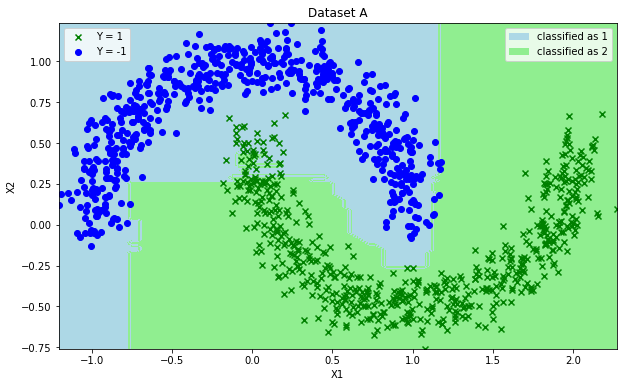

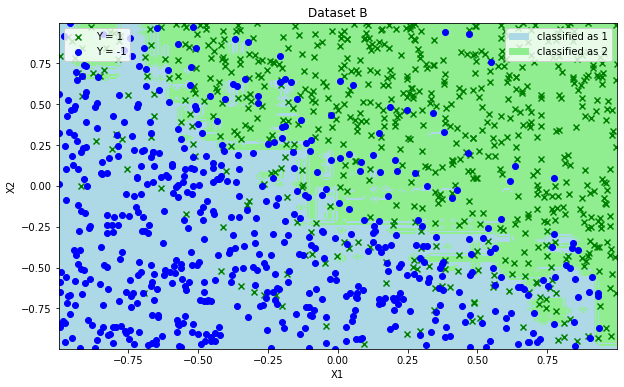

In [0]:
## Codewrite cell: Generate plots of learned Random Forest classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots required only for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 
for ind, ch in enumerate(['A','B']):
    st_xtr="dataset_"+ch+"/arr_0.npy"
    st_ytr="dataset_"+ch+"/arr_1.npy"
    st_xte="dataset_"+ch+"/arr_2.npy"
    st_yte="dataset_"+ch+"/arr_3.npy"
    
    X_train=np.load(st_xtr)
    Y_train=np.load(st_ytr)
    X_test=np.load(st_xte)
    Y_test=np.load(st_yte)

    #print(str(len(X_train)))
    X_tr=X_train[:int(0.8*(len(X_train)))]
    Y_tr=Y_train[:int(0.8*(len(Y_train)))]
    
    tree=getForest(ch, 'accuracy')
    
    n1=100
    n2=100
    x1 = np.linspace(np.min(X_tr.T[0]),np.max(X_tr.T[0]),n1)
    x2 = np.linspace(np.min(X_tr.T[1]),np.max(X_tr.T[1]),n2)
    x1,x2 = np.meshgrid(x1,x2)
    x1 = x1.reshape((n1*n2,1))
    x2 = x2.reshape((n1*n2,1))
    x  = np.concatenate((x1,x2),axis=1)
    x1 =x1.reshape((n1,n2))
    x2 =x2.reshape((n1,n2))

    yp=eval_random_forest(tree,x,Y_va)
    yp =yp.reshape((n1,n2))
    
    
    plt.figure(figsize = (10,6))
    plt.gca().set_title("Dataset "+ch)
    plt.gca().set_ylabel("X2")
    plt.gca().set_xlabel("X1")
    a=plt.contourf(x1,x2,yp,colors = ["lightblue", "lightgreen"])
    plt.scatter(X_tr[Y_tr==1].T[0], X_tr[Y_tr==1].T[1], c="g", label = "Y = 1", marker='x')
    plt.scatter(X_tr[Y_tr==-1].T[0], X_tr[Y_tr==-1].T[1], c="b", label= "Y = -1", marker='o')
    contour = plt.legend(loc = "upper left")
    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in a.collections]
    plt.legend(proxy, ["classified as " + str(i+1) for i in range(2)], loc = "upper right")    
    plt.gca().add_artist(contour)
    plt.show()